In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 500)

### Importing data

In [3]:
team_stats = pd.read_csv('./Data/clean NHL data.csv', index_col=0)
player_stats = pd.read_csv('./Data/full player stats.csv', index_col=0)
advanced_stats = pd.read_csv('./Data/full advanced stats.csv', index_col=0)

### Correlations to rank

- Because the teams are ranked 1-31 a high positive correlation to rank is actually indicative of poor team performance, and a high negative correlation is indicative of good team performance. I will be inverting the y-axes on my graphs to account for this.
- Lets take a look at the top factors correlated with rank

In [4]:
team_stats.drop(['cup_champs', 'rank', 'team_name'], axis=1).apply(lambda x: x.corr(team_stats['rank'])).abs().sort_values(ascending=False)

points_pct              0.880801
srs                     0.849914
losses                  0.741982
wins                    0.712076
points                  0.673887
save_pct                0.540869
pdo                     0.532145
opp_goals               0.454419
pen_kill_pct            0.438920
goals_against_ev        0.433990
shot_pct                0.384523
goals                   0.369692
power_play_pct          0.361376
goals_ev                0.345577
sos                     0.309770
opp_goals_pp            0.288034
goals_pp                0.269427
average_age             0.184434
losses_ot               0.176417
shots_against           0.174218
shots                   0.170792
wins_shootout           0.130071
opp_goals_sh            0.126927
total_goals_per_game    0.120367
goals_sh                0.092118
chances_pp              0.046927
pen_min_per_game        0.042048
losses_shootout         0.041478
pen_min_per_game_opp    0.022916
opp_chances_pp          0.013371
year      

#### Problems with this data
Trying to predict who will win the Stanley Cup, or any sporting championship for that matter, is a particularly difficult task. Many have tried with varying degrees of success, but there is no "magic model" out there that is performing head and shoulders above the rest (And if there was, there would be someone out there making a lot of money). This is the nature of predicting sports outcomes.
 - In order to maintain some level of predictability I have decided to include summary performance statistics like wins, losses and points. While these are not predictive of who will win the Stanley Cup, they are directly responsible for who makes the playoffs, and thus the 'rank' of the team at the end of the season.

 - Let's look at the top statistics correlated with team rank. I'm throwing the 'cup_champs' column in there as well to see if relationships exist there as well.

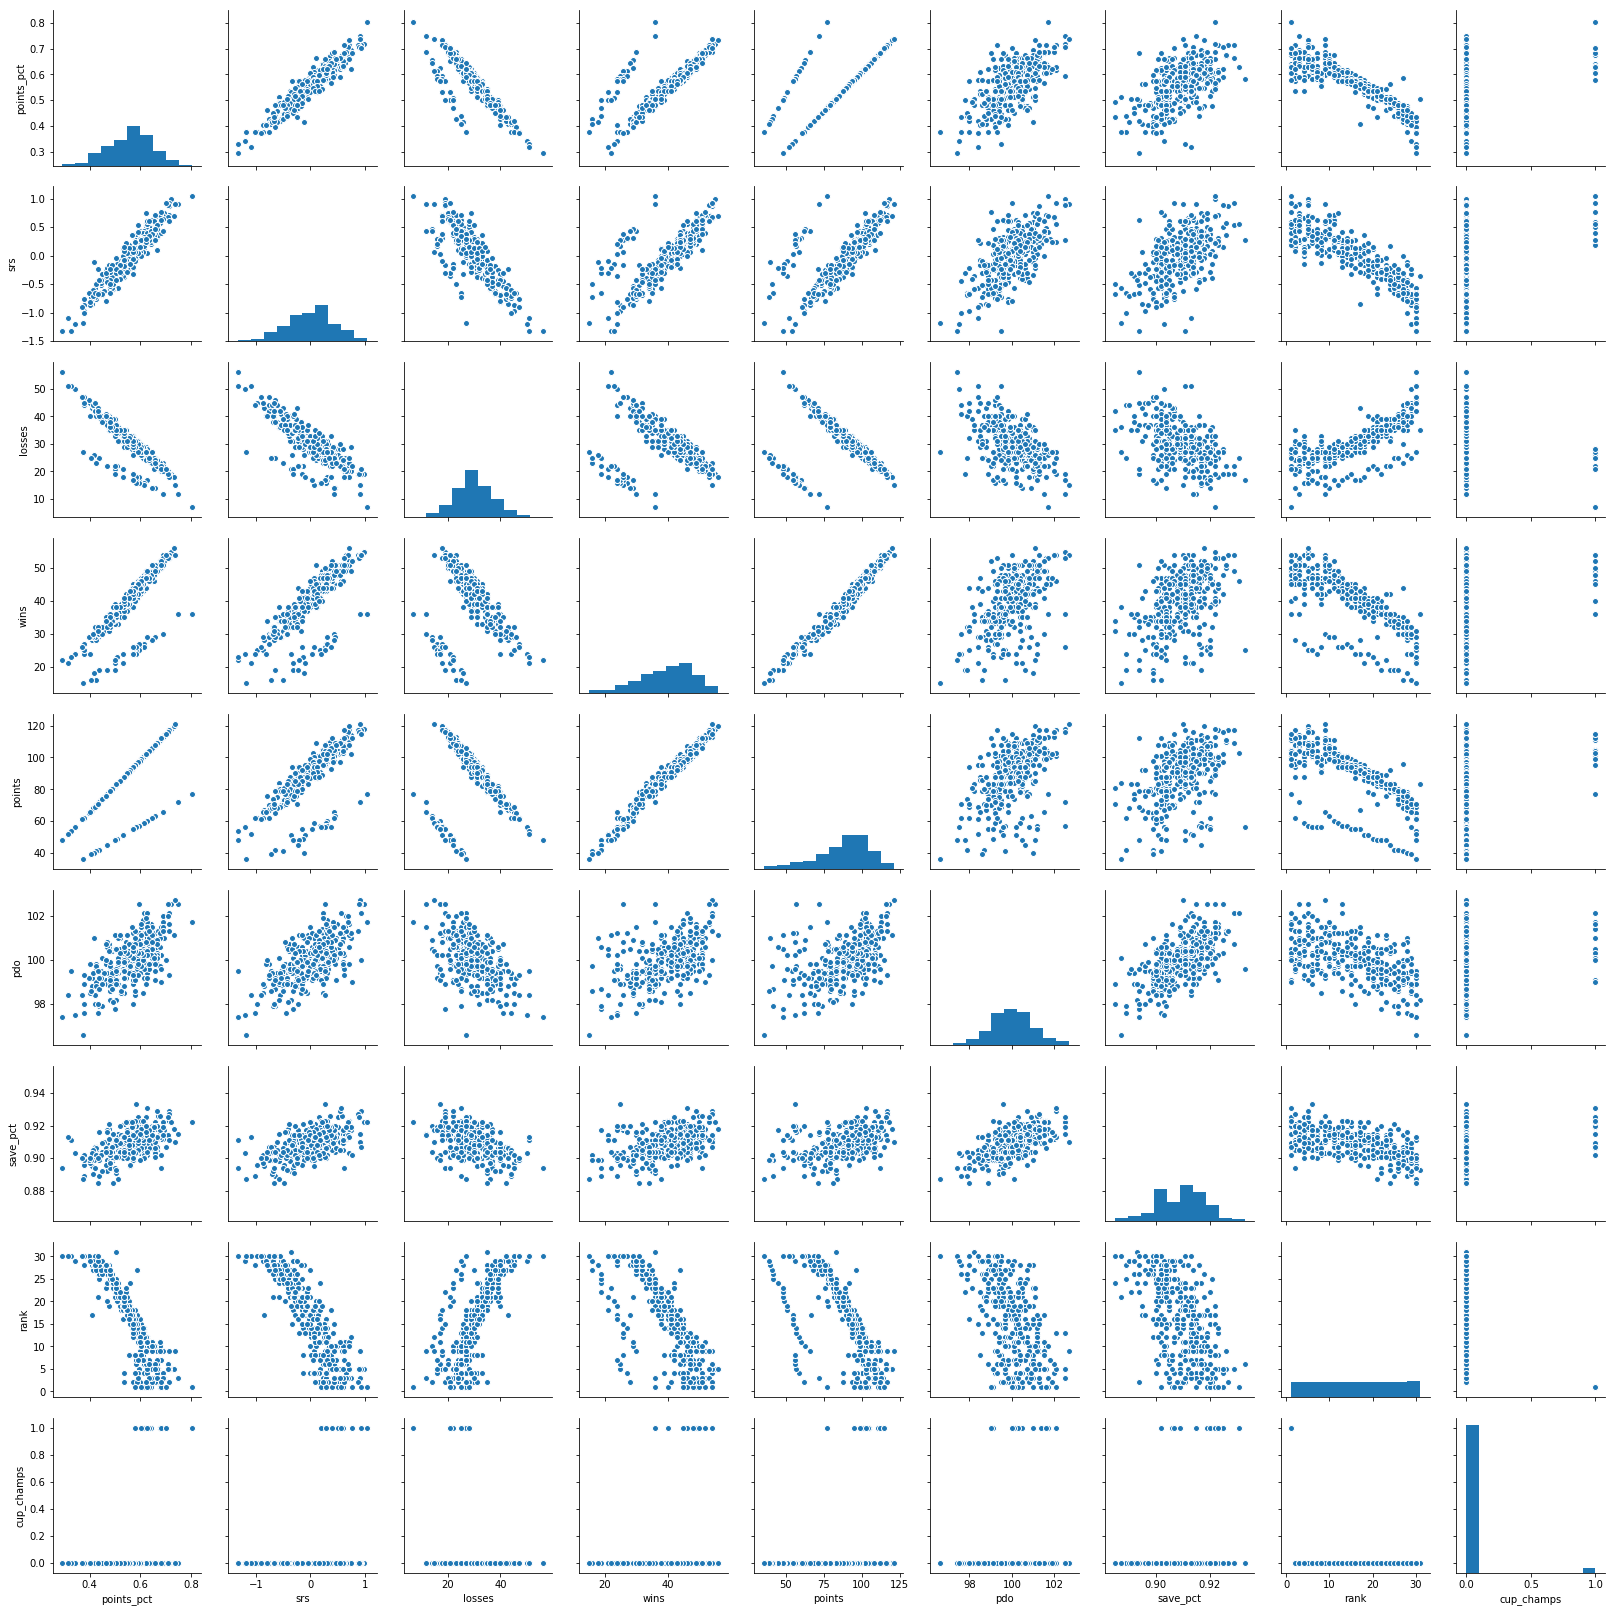

In [5]:
sns.pairplot(team_stats[['points_pct', 'srs', 'losses', 'wins', 'points', 'pdo', 'save_pct', 'rank', 'cup_champs']])

  ---

### Feature Engineering

Need to clean up a few of the column names to make sure they are consistent across all of the dataframes, as I will be merging quite a few things going forward.

In [6]:
advanced_stats['team'] = advanced_stats['team'].replace('[^A-Za-z ]', '', regex=True)
player_stats['team'] = player_stats['team'].replace('[^A-Za-z ]', '', regex=True)

In [7]:
advanced_stats.rename(columns={'team': 'team_name'}, inplace=True)
player_stats.rename(columns={'team': 'team_name'}, inplace=True)

##### Function to transform individual stats into team averages to be used in the team stats dataframe

In [8]:
def agg_stat(dataframe, col_name):
    y = dataframe.groupby(by=['year', 'team_name'])[col_name].mean().unstack()
    y.reset_index(inplace=True)
    y = pd.melt(y, id_vars=['year'])
    return y

##### Corsi Percentage:

- Corsi is an individual player stat that calculates shots on goal + shots that are blocked + shot attempts that miss the goal. The stat is calculated as CF, or Corsi For and CA, or Corsi Against. A Corsi percentage is calculated for each player by taking CF/(CF + CA). A Corsi For Percentage over %50, means that the team was controlling the puck more often than not when that particular player is on the ice. To turn this into a team statistic I have taken the mean of the Corsi For Percentage for each player on a given team in a given year. The idea is we get a clearer view of the team's overall puck posession in that season.

In [9]:
corsi_pct = agg_stat(advanced_stats, 'corsi_pct')

team_stats = pd.merge(team_stats, corsi_pct, on=['year', 'team_name'])

team_stats.rename(columns={'value': 'avg_corsi_pct'}, inplace=True)

##### Player Point Average:

 - A point in hockey is an individual statistic. 1 point is awarded for a goal and 1 point for an assist.  This player point average takes the mean of points scored for all players on the team. This transfers an individual statistic to a team statistic, and a team with a higher player point average can be said to have a more efficient offense.

In [10]:
player_point_avg = agg_stat(player_stats, 'points')

team_stats = pd.merge(team_stats, player_point_avg, on=['year', 'team_name'])

team_stats.rename(columns={'value': 'player_point_avg'}, inplace=True)

##### Average Plus Minus:

 - Plus Minus is an individual statistic that measure the goal differential while that player is on the ice. If your team scores while you are on the ice, your plus/minus increases by 1, and decreases by 1 if your team is scored against while you are on the ice. Average Plus Minus is the mean of every individual's plus minus on a given team. This is closely related to a team's goal differential.

In [11]:
avg_plus_minus = agg_stat(player_stats, 'plus_minus')

team_stats = pd.merge(team_stats, avg_plus_minus, on=['year', 'team_name'])

team_stats.rename(columns={'value': 'avg_plus_minus'}, inplace=True)

##### Average Point Share (PS):

 - point shares is an advanced statistic that estimates how many points in the team standings an individual player is responsible for. There are similar statistics in Baseball and Basketball. Point shares are calculated for both offense and defense. The offensive point share measures how many points in team standings an individual player is responsible for due to their offense. The defensive point share measures how many team points in team standings an individual player is responsible for due to their defense. I have calculated the team averages for both of these statistics below.

In [12]:
avg_ops = agg_stat(player_stats, 'ops')

team_stats = pd.merge(team_stats, avg_ops, on=['year', 'team_name'])

team_stats.rename(columns={'value': 'avg_ops'}, inplace=True)

In [13]:
avg_dps = agg_stat(player_stats, 'dps')

team_stats = pd.merge(team_stats, avg_dps, on=['year', 'team_name'])

team_stats.rename(columns={'value': 'avg_dps'}, inplace=True)

In [14]:
avg_ps = agg_stat(player_stats, 'point_shares')

team_stats = pd.merge(team_stats, avg_ps, on=['year', 'team_name'])

team_stats.rename(columns={'value': 'avg_ps'}, inplace=True)

##### Fenwick Percentage:

 - Fenwick is an individual player stat that calculates shots on goal + shot attempts that miss the goal. This statistic is very similar to Corsi, but does not include blocked shots in its calculation. Again, the ultimate idea is to quantify puck control and posession.

In [15]:
fenwick_pct = agg_stat(advanced_stats, 'fenwick_pct')

team_stats = pd.merge(team_stats, fenwick_pct, on=['year', 'team_name'])

team_stats.rename(columns={'value': 'fenwick_pct'}, inplace=True)

In [16]:
team_stats.head()

average_age  chances_pp  games  goals  goals_against_ev  goals_ev  \
0         28.4       274.0   82.0  267.0             145.0     193.0   
1         26.8       274.0   82.0  277.0             159.0     200.0   
2         27.5       276.0   82.0  296.0             172.0     216.0   
3         28.6       258.0   82.0  270.0             161.0     197.0   
4         28.0       248.0   82.0  272.0             182.0     218.0   

   goals_pp  goals_sh  losses  losses_ot  losses_shootout  opp_chances_pp  \
0      58.0      10.0    18.0       11.0              7.0           299.0   
1      64.0       9.0    20.0       10.0              2.0           274.0   
2      66.0       9.0    23.0        5.0              2.0           267.0   
3      61.0       9.0    20.0       12.0              3.0           245.0   
4      53.0       8.0    24.0        7.0              3.0           237.0   

   opp_goals  opp_goals_pp  opp_goals_sh    pdo  pen_kill_pct  \
0      211.0          54.0           5.0  101.6         81.94   
1      218.0          50.0           7.0  101.0         81.75   
2      236.0          64.0           3.0  102.0         76.03   
3      214.0          40.0          10.0  100.2         83.67   
4      228.0          44.0           5.0  100.5         81.43   

   pen_min_per_game  pen_min_per_game_opp  points  points_pct  power_play_pct  \
0              11.3                   9.6   117.0       0.713           21.17   
1               8.5                   8.6   114.0       0.695           23.36   
2              10.1                  10.4   113.0       0.689           23.91   
3               9.5                   9.6   112.0       0.683           23.64   
4               7.1                   7.8   109.0       0.665           21.37   

   save_pct  shot_pct   shots  shots_against   sos   srs  \
0     0.923       9.9  2641.0         2659.0  0.03  0.71   
1     0.917      10.3  2643.0         2613.0  0.02  0.74   
2     0.912      10.7  2737.0         2756.0 -0.07  0.66   
3     0.912       9.9  2703.0         2399.0 -0.07  0.62   
4     0.911      10.1  2774.0         2619.0 -0.01  0.52   

              team_name  total_goals_per_game  wins  wins_shootout  year  \
0   Nashville Predators                  5.83  53.0            6.0  2018   
1         Winnipeg Jets                  6.04  52.0            4.0  2018   
2   Tampa Bay Lightning                  6.49  54.0            6.0  2018   
3         Boston Bruins                  5.90  50.0            3.0  2018   
4  Vegas Golden Knights                  6.10  51.0            4.0  2018   

   cup_champs  rank  avg_corsi_pct  player_point_avg  avg_plus_minus  \
0         0.0     5      49.660000         25.481481        9.185185   
1         0.0     3      51.061538         26.285714        7.250000   
2         0.0     4      51.536000         28.962963        9.333333   
3         0.0     7      53.162069         23.161290        5.419355   
4         0.0     2      50.779167         26.000000        5.037037   

    avg_ops   avg_dps    avg_ps  fenwick_pct  
0  1.692593  1.700000  4.103704    49.836000  
1  1.792857  1.567857  3.925000    51.357692  
2  2.103704  1.407407  4.085185    51.576000  
3  1.554839  1.509677  3.512903    53.320690  
4  1.788889  1.518519  3.807407    50.770833

   ---

- Absolute value of correlations to rank

In [17]:
team_stats.drop(['rank', 'team_name'], axis=1).apply(lambda x: x.corr(team_stats['rank'])).abs().sort_values(ascending=False)

points_pct              0.880801
srs                     0.849914
avg_plus_minus          0.806557
losses                  0.741982
wins                    0.712076
avg_ps                  0.688955
points                  0.673887
avg_dps                 0.653882
avg_ops                 0.579923
save_pct                0.540869
pdo                     0.532145
player_point_avg        0.474013
fenwick_pct             0.470946
opp_goals               0.454419
pen_kill_pct            0.438920
goals_against_ev        0.433990
avg_corsi_pct           0.425548
shot_pct                0.384523
goals                   0.369692
power_play_pct          0.361376
goals_ev                0.345577
cup_champs              0.310573
sos                     0.309770
opp_goals_pp            0.288034
goals_pp                0.269427
average_age             0.184434
losses_ot               0.176417
shots_against           0.174218
shots                   0.170792
wins_shootout           0.130071
opp_goals_

##### Removing the least correlated features

In [19]:
full_df = team_stats.drop(['average_age', 'losses_ot', 'shots_against',
                 'shots', 'wins_shootout', 'opp_goals_sh', 'total_goals_per_game',
                 'goals_sh', 'chances_pp', 'pen_min_per_game',
                 'losses_shootout', 'pen_min_per_game_opp', 'opp_chances_pp'], axis=1)

In [20]:
full_df.head()

games  goals  goals_against_ev  goals_ev  goals_pp  losses  opp_goals  \
0   82.0  267.0             145.0     193.0      58.0    18.0      211.0   
1   82.0  277.0             159.0     200.0      64.0    20.0      218.0   
2   82.0  296.0             172.0     216.0      66.0    23.0      236.0   
3   82.0  270.0             161.0     197.0      61.0    20.0      214.0   
4   82.0  272.0             182.0     218.0      53.0    24.0      228.0   

   opp_goals_pp    pdo  pen_kill_pct  points  points_pct  power_play_pct  \
0          54.0  101.6         81.94   117.0       0.713           21.17   
1          50.0  101.0         81.75   114.0       0.695           23.36   
2          64.0  102.0         76.03   113.0       0.689           23.91   
3          40.0  100.2         83.67   112.0       0.683           23.64   
4          44.0  100.5         81.43   109.0       0.665           21.37   

   save_pct  shot_pct   sos   srs             team_name  wins  year  \
0     0.923       9.9  0.03  0.71   Nashville Predators  53.0  2018   
1     0.917      10.3  0.02  0.74         Winnipeg Jets  52.0  2018   
2     0.912      10.7 -0.07  0.66   Tampa Bay Lightning  54.0  2018   
3     0.912       9.9 -0.07  0.62         Boston Bruins  50.0  2018   
4     0.911      10.1 -0.01  0.52  Vegas Golden Knights  51.0  2018   

   cup_champs  rank  avg_corsi_pct  player_point_avg  avg_plus_minus  \
0         0.0     5      49.660000         25.481481        9.185185   
1         0.0     3      51.061538         26.285714        7.250000   
2         0.0     4      51.536000         28.962963        9.333333   
3         0.0     7      53.162069         23.161290        5.419355   
4         0.0     2      50.779167         26.000000        5.037037   

    avg_ops   avg_dps    avg_ps  fenwick_pct  
0  1.692593  1.700000  4.103704    49.836000  
1  1.792857  1.567857  3.925000    51.357692  
2  2.103704  1.407407  4.085185    51.576000  
3  1.554839  1.509677  3.512903    53.320690  
4  1.788889  1.518519  3.807407    50.770833

### Creating balanced scoring feature

 - First I need to separate the player stats by year

In [22]:
stats_2018 = player_stats[player_stats['year'] == 2018]
stats_2017 = player_stats[player_stats['year'] == 2017]
stats_2016 = player_stats[player_stats['year'] == 2016]
stats_2015 = player_stats[player_stats['year'] == 2015]
stats_2014 = player_stats[player_stats['year'] == 2014]
stats_2013 = player_stats[player_stats['year'] == 2013]
stats_2012 = player_stats[player_stats['year'] == 2012]
stats_2011 = player_stats[player_stats['year'] == 2011]
stats_2010 = player_stats[player_stats['year'] == 2010]
stats_2009 = player_stats[player_stats['year'] == 2009]
stats_2008 = player_stats[player_stats['year'] == 2008]

 - Next I need to exclude goaltenders for this calculation

In [23]:
skater_2018 = stats_2018[stats_2018['position'] != 'G']
skater_2017 = stats_2017[stats_2017['position'] != 'G']
skater_2016 = stats_2016[stats_2016['position'] != 'G']
skater_2015 = stats_2015[stats_2015['position'] != 'G']
skater_2014 = stats_2014[stats_2014['position'] != 'G']
skater_2013 = stats_2013[stats_2013['position'] != 'G']
skater_2012 = stats_2012[stats_2012['position'] != 'G']
skater_2011 = stats_2011[stats_2011['position'] != 'G']
skater_2010 = stats_2010[stats_2010['position'] != 'G']
skater_2009 = stats_2009[stats_2009['position'] != 'G']
skater_2008 = stats_2008[stats_2008['position'] != 'G']

 - Concatenating the dataframes together with no goaltenders

In [24]:
full_skater_df = pd.concat([skater_2018, skater_2017, skater_2016,
                           skater_2015, skater_2014, skater_2013,
                           skater_2012, skater_2011, skater_2010,
                           skater_2009, skater_2008], axis=0)
full_skater_df.reset_index(drop=True, inplace=True)

In [25]:
full_skater_df.head()

age  assists  dps  es_assists  es_blocks  es_faceoff_losses  \
0  24.0       35  1.9        25.0       30.0              121.0   
1  32.0       50  2.1        36.0       57.0              443.0   
2  32.0       32  1.2        25.0       36.0               14.0   
3  27.0       23  1.8        16.0       61.0               35.0   
4  22.0       18  1.7        16.0       26.0               21.0   

   es_faceoff_pct  es_faceoff_wins  es_goals  es_hits  games_played  goals  \
0            46.5            105.0        26      115            77     34   
1            47.8            406.0        10       96            56     11   
2            12.5              2.0        13       59            71     17   
3            34.0             18.0        14       52            77     17   
4            19.2              5.0        19       28            66     20   

   gw_goals  ops  penalty_minutes             player  plus_minus  \
0         3  6.4               14     Rickard Rakell         6.0   
1         0  4.0               42       Ryan Getzlaf        20.0   
2         1  3.3               71        Corey Perry        -4.0   
3         2  2.0               18  Jakob Silfverberg         6.0   
4         5  3.4               14        Ondrej Kase        18.0   

   point_shares  points position  pp_assists  pp_goals  sh_assists  sh_goals  \
0           8.3      69       RW        10.0         8         0.0         0   
1           6.2      61        C        13.0         0         1.0         1   
2           4.5      49       RW         7.0         4         0.0         0   
3           3.8      40       LW         6.0         2         1.0         1   
4           5.1      38       RW         2.0         1         0.0         0   

   shot_pct  shots      team_name   toi toi_avg  year  
0      14.8    230  Anaheim Ducks  1495   19:25  2018  
1       9.4    117  Anaheim Ducks  1200   21:26  2018  
2      10.1    168  Anaheim Ducks  1262   17:47  2018  
3       9.1    187  Anaheim Ducks  1383   17:58  2018  
4      13.7    146  Anaheim Ducks   919   13:55  2018

##### The Balanced Scoring Function:

 - This function takes in a dataframe of all skaters (excluding goaltenders) in a given year. The function returns a balanced scoring dataframe for that given year. Balanced scoring is calculated by taking the average of points scored for all players in that year. Then the standard deviation for points scored in that year is calculated and added to the mean. This finds all of the players who scored a number of points that is one standard deviation above the mean for that year. Essentially, these are a teams top scorers. Next, this calculates what percentage of players on a given team are a part of the 'top scorers' class. This percentage is found by dividing the number of top scorers on a given team by 18 (18 is the number of skaters that dress in a given game). Finally, the function returns a dataframe which includes the team, the balanced scoring calculation, and the year as columns. 

In [26]:
def df_builder(dataframe, year):
    pts_mean = dataframe['points'].mean()
    pts_std = dataframe['points'].std()
    high_points = pts_mean + pts_std
    df = dataframe[dataframe['points'] > high_points]
    df = df.groupby('team_name').count() / 18
    df.rename(columns={'age': 'score_balance_pct'}, inplace=True)
    df = df['score_balance_pct'].reset_index()
    df['year'] = year
    pct_top_scorers = df
    return pct_top_scorers

In [49]:
pts_mean_2014 = skater_2014['points'].mean()
pts_std_2014 = skater_2014['points'].std()
high_points_2014 = pts_mean_2014 + pts_std_2014

high_2014 = skater_2014[skater_2014['points'] > high_points_2014]
high_2014[high_2014['team_name'] == 'Florida Panthers']

Empty DataFrame
Columns: [age, assists, dps, es_assists, es_blocks, es_faceoff_losses, es_faceoff_pct, es_faceoff_wins, es_goals, es_hits, games_played, goals, gw_goals, ops, penalty_minutes, player, plus_minus, point_shares, points, position, pp_assists, pp_goals, sh_assists, sh_goals, shot_pct, shots, team_name, toi, toi_avg, year]
Index: []

 - Each year's dataframe is saved in a variable below

In [27]:
score_balance_pct_2018 = df_builder(skater_2018, 2018)
score_balance_pct_2017 = df_builder(skater_2017, 2017)
score_balance_pct_2016 = df_builder(skater_2016, 2016)
score_balance_pct_2015 = df_builder(skater_2015, 2015)
score_balance_pct_2014 = df_builder(skater_2014, 2014)
score_balance_pct_2013 = df_builder(skater_2013, 2013)
score_balance_pct_2012 = df_builder(skater_2012, 2012)
score_balance_pct_2011 = df_builder(skater_2011, 2011)
score_balance_pct_2010 = df_builder(skater_2010, 2010)
score_balance_pct_2009 = df_builder(skater_2009, 2009)
score_balance_pct_2008 = df_builder(skater_2008, 2008)

In [45]:
score_balance_pct_2014

team_name  score_balance_pct  year
0           Anaheim Ducks           0.277778  2014
1           Boston Bruins           0.388889  2014
2          Buffalo Sabres           0.111111  2014
3          Calgary Flames           0.166667  2014
4     Carolina Hurricanes           0.222222  2014
5      Chicago Blackhawks           0.333333  2014
6      Colorado Avalanche           0.277778  2014
7   Columbus Blue Jackets           0.166667  2014
8            Dallas Stars           0.166667  2014
9       Detroit Red Wings           0.222222  2014
10        Edmonton Oilers           0.222222  2014
11      Los Angeles Kings           0.166667  2014
12         Minnesota Wild           0.222222  2014
13     Montreal Canadiens           0.277778  2014
14    Nashville Predators           0.222222  2014
15      New Jersey Devils           0.277778  2014
16     New York Islanders           0.222222  2014
17       New York Rangers           0.277778  2014
18        Ottawa Senators           0.277778  2014
19    Philadelphia Flyers           0.277778  2014
20        Phoenix Coyotes           0.777778  2014
21    Pittsburgh Penguins           0.333333  2014
22        San Jose Sharks           0.277778  2014
23         St Louis Blues           0.388889  2014
24    Tampa Bay Lightning           0.333333  2014
25    Toronto Maple Leafs           0.333333  2014
26      Vancouver Canucks           0.166667  2014
27    Washington Capitals           0.333333  2014
28          Winnipeg Jets           0.333333  2014

 - Concatenating the years together into one dataframe

In [29]:
full_score_balance = pd.concat([score_balance_pct_2018, score_balance_pct_2017, 
                                score_balance_pct_2016, score_balance_pct_2015, 
                                score_balance_pct_2014, score_balance_pct_2013, 
                                score_balance_pct_2012, score_balance_pct_2011,
                                score_balance_pct_2010, score_balance_pct_2009,
                                score_balance_pct_2008], axis=0)

full_score_balance.head()

team_name  score_balance_pct  year
0    Anaheim Ducks           0.166667  2018
1  Arizona Coyotes           0.111111  2018
2    Boston Bruins           0.277778  2018
3   Buffalo Sabres           0.166667  2018
4   Calgary Flames           0.166667  2018

 - Merging the dataframe together with the full_stats dataframe

In [30]:
full_df = pd.merge(full_df, full_score_balance, how='outer', on=['team_name', 'year'])

##### Lets look at the top correlations including the features that have been engineered

In [31]:
correlations = full_df.drop(['rank', 'team_name'], axis=1).apply(lambda x: x.corr(full_df['rank'])).abs().sort_values(ascending=False)

In [32]:
correlations

points_pct           0.880801
srs                  0.849914
avg_plus_minus       0.806557
losses               0.741982
wins                 0.712076
avg_ps               0.688955
points               0.673887
avg_dps              0.653882
avg_ops              0.579923
save_pct             0.540869
pdo                  0.532145
player_point_avg     0.474013
fenwick_pct          0.470946
opp_goals            0.454419
pen_kill_pct         0.438920
goals_against_ev     0.433990
score_balance_pct    0.430032
avg_corsi_pct        0.425548
shot_pct             0.384523
goals                0.369692
power_play_pct       0.361376
goals_ev             0.345577
cup_champs           0.310573
sos                  0.309770
opp_goals_pp         0.288034
goals_pp             0.269427
year                 0.008481
games                0.001702
dtype: float64

 - The engineered features seem okay. They are not more highly correlated than the summary team statistics like wins, losses and point percentage. But, some of them do show strong correlations to rank which is somewhat encouraging.
 - Let's look at some visualizations.

  ---

### Graphing Relationships

Text(0.5, 1.0, 'Corsi Percentage Relative to Team Rank')

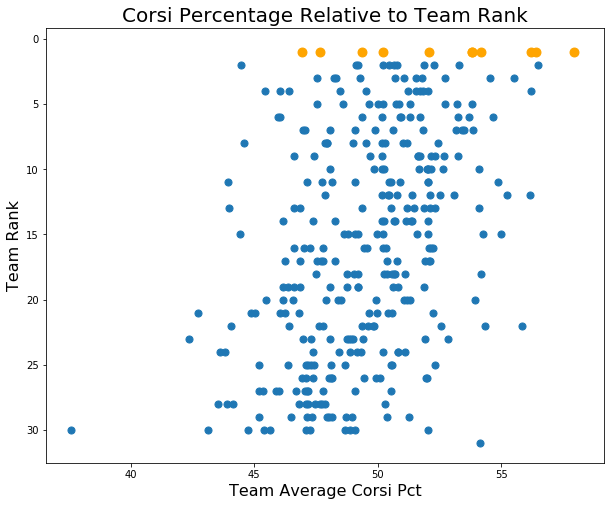

In [33]:
champs = team_stats[team_stats['rank'] == 1]
corsi_champs = champs['avg_corsi_pct'].copy()
champs_corsi = corsi_champs.tolist()


plt.figure(figsize=(10, 8))
plt.scatter(team_stats['avg_corsi_pct'], team_stats['rank'], s=50)
plt.scatter(champs_corsi, champs['rank'], s=80, c='orange')
plt.gca().invert_yaxis()
plt.xlabel('Team Average Corsi Pct', fontsize=16)
plt.ylabel('Team Rank', fontsize=16)
plt.title('Corsi Percentage Relative to Team Rank', fontsize=20)

Text(0.5, 1.0, 'Average Plus Minus Relative to Team Rank')

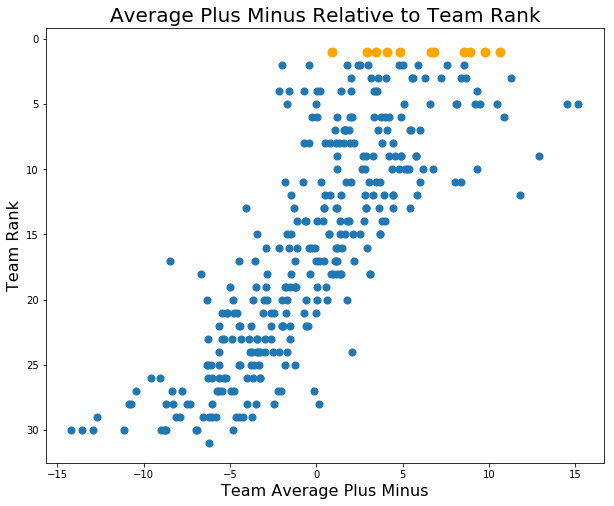

In [34]:
champs = team_stats[team_stats['rank'] == 1]
plsmin_champs = champs['avg_plus_minus'].copy()
champs_plsmin = plsmin_champs.tolist()

plt.figure(figsize=(10, 8))
plt.scatter(team_stats['avg_plus_minus'], team_stats['rank'], s=50)
plt.scatter(champs_plsmin, champs['rank'], s=80, c='orange')
plt.gca().invert_yaxis()
plt.xlabel('Team Average Plus Minus', fontsize=16)
plt.ylabel('Team Rank', fontsize=16)
plt.title('Average Plus Minus Relative to Team Rank', fontsize=20)

Text(0.5, 1.0, 'Scoring Balance Relative to Team Rank')

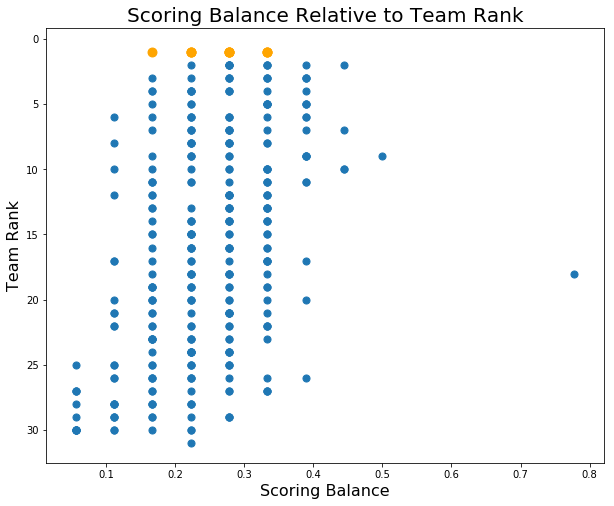

In [35]:
champs = full_df[full_df['rank'] == 1]
score_balance_champs = champs['score_balance_pct'].copy()
champs_score_balance = score_balance_champs.tolist()

plt.figure(figsize=(10, 8))
plt.scatter(full_df['score_balance_pct'], team_stats['rank'], s=50)
plt.scatter(champs_score_balance, champs['rank'], s=80, c='orange')
plt.gca().invert_yaxis()
plt.xlabel('Scoring Balance', fontsize=16)
plt.ylabel('Team Rank', fontsize=16)
plt.title('Scoring Balance Relative to Team Rank', fontsize=20)

Text(0, 0.5, 'Score Balance Percentage')

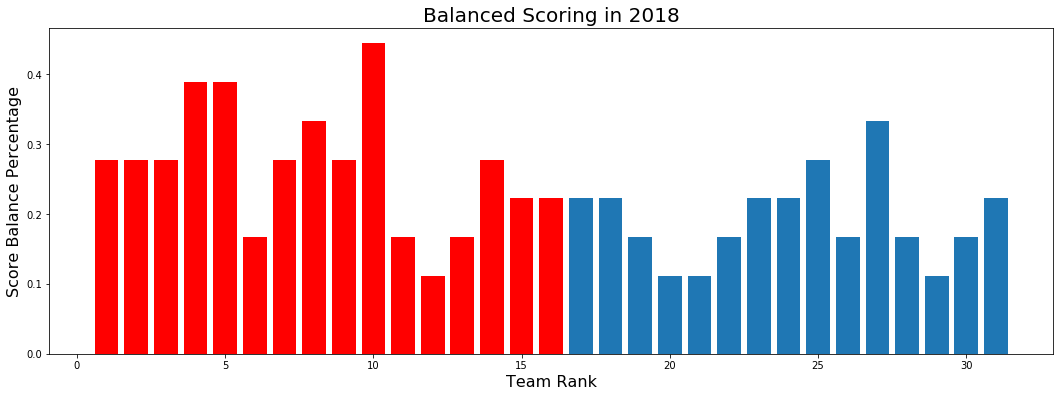

In [36]:
df_2018 = full_df[full_df['year'] == 2018]
df_2018_playoffs = df_2018[df_2018['rank'] <= 16]
df_2018_bottom = df_2018[df_2018['rank'] > 16]

plt.figure(figsize=(18,6))
bar1 = plt.bar(x = df_2018_playoffs['rank'], height = df_2018_playoffs['score_balance_pct'], color='r')
bar2 = plt.bar(x = df_2018_bottom['rank'], height = df_2018_bottom['score_balance_pct'])
plt.title('Balanced Scoring in 2018', fontsize=20)
plt.xlabel('Team Rank', fontsize=16)
plt.ylabel('Score Balance Percentage', fontsize=16)

Text(0, 0.5, 'Score Balance Percentage')

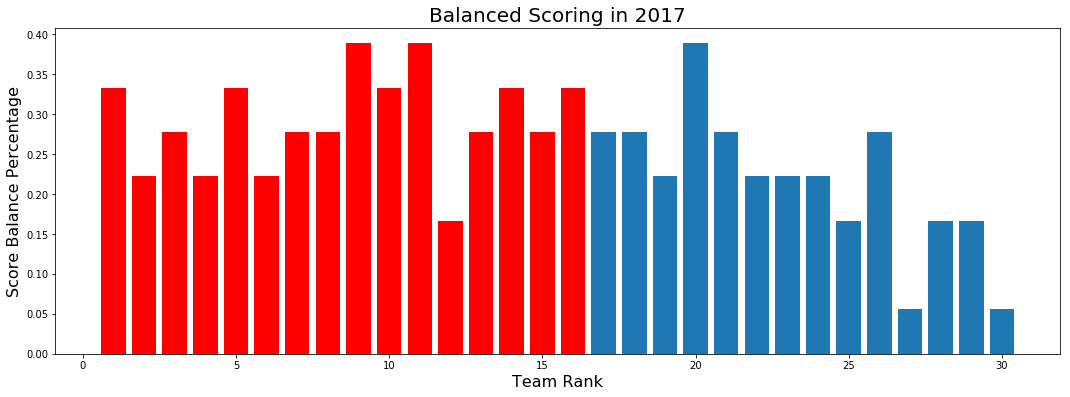

In [37]:
df_2017 = full_df[full_df['year'] == 2017]
df_2017_playoffs = df_2017[df_2017['rank'] <= 16]
df_2017_bottom = df_2017[df_2017['rank'] > 16]

plt.figure(figsize=(18,6))
bar1 = plt.bar(x = df_2017_playoffs['rank'], height = df_2017_playoffs['score_balance_pct'], color='r')
bar2 = plt.bar(x = df_2017_bottom['rank'], height = df_2017_bottom['score_balance_pct'])
plt.title('Balanced Scoring in 2017', fontsize=20)
plt.xlabel('Team Rank', fontsize=16)
plt.ylabel('Score Balance Percentage', fontsize=16)

 - I realized I don't have any goal differential features. I'm adding them here, for both even strength and special teams.

In [38]:
full_df['ev_goal_diff'] = full_df['goals_ev'] - full_df['goals_against_ev']
full_df['special_teams_diff'] = full_df['goals_pp'] - full_df['opp_goals_pp']

Text(0, 0.5, 'ES Goal Differential')

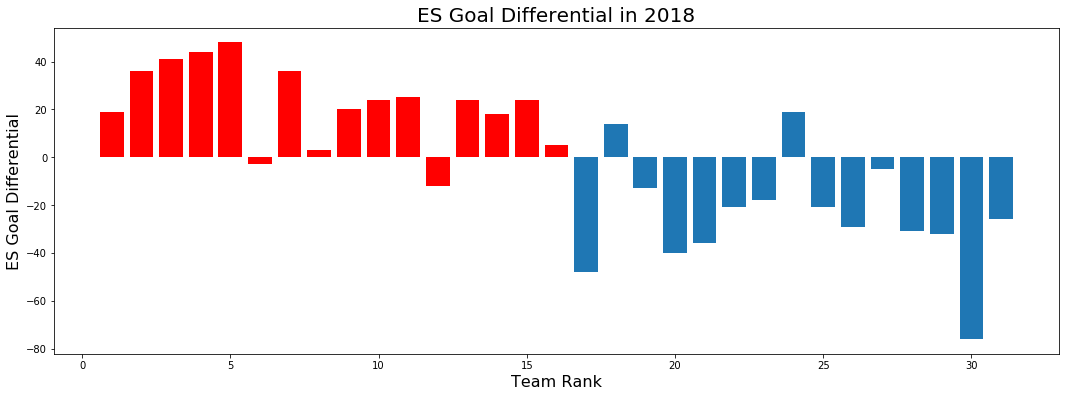

In [39]:
df_2018 = full_df[full_df['year'] == 2018]
df_2018_playoffs = df_2018[df_2018['rank'] <= 16]
df_2018_bottom = df_2018[df_2018['rank'] > 16]

plt.figure(figsize=(18,6))
bar1 = plt.bar(x = df_2018_playoffs['rank'], height = df_2018_playoffs['ev_goal_diff'], color='r')
bar2 = plt.bar(x = df_2018_bottom['rank'], height = df_2018_bottom['ev_goal_diff'])
plt.title('ES Goal Differential in 2018', fontsize=20)
plt.xlabel('Team Rank', fontsize=16)
plt.ylabel('ES Goal Differential', fontsize=16)

Text(0, 0.5, 'Special Teams Differential')

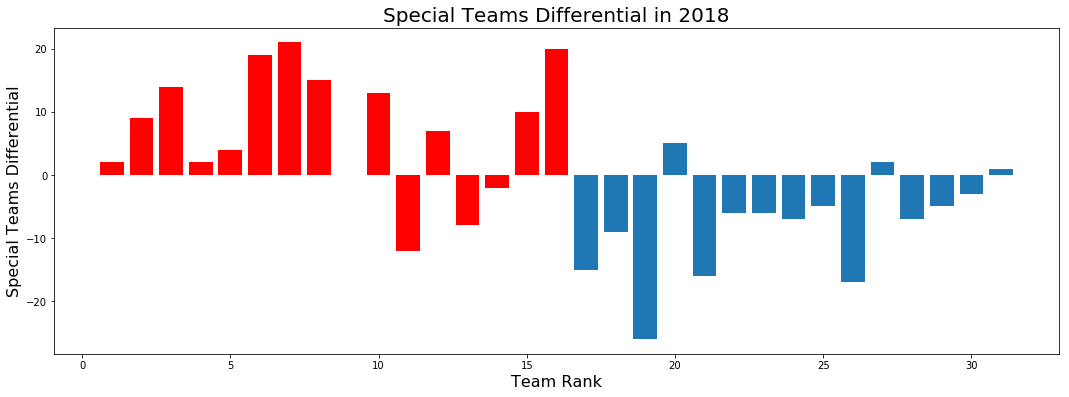

In [40]:
df_2018 = full_df[full_df['year'] == 2018]
df_2018_playoffs = df_2018[df_2018['rank'] <= 16]
df_2018_bottom = df_2018[df_2018['rank'] > 16]

plt.figure(figsize=(18,6))
bar1 = plt.bar(x = df_2018_playoffs['rank'], height = df_2018_playoffs['special_teams_diff'], color='r')
bar2 = plt.bar(x = df_2018_bottom['rank'], height = df_2018_bottom['special_teams_diff'])
plt.title('Special Teams Differential in 2018', fontsize=20)
plt.xlabel('Team Rank', fontsize=16)
plt.ylabel('Special Teams Differential', fontsize=16)

Text(0, 0.5, 'Simple Rating System')

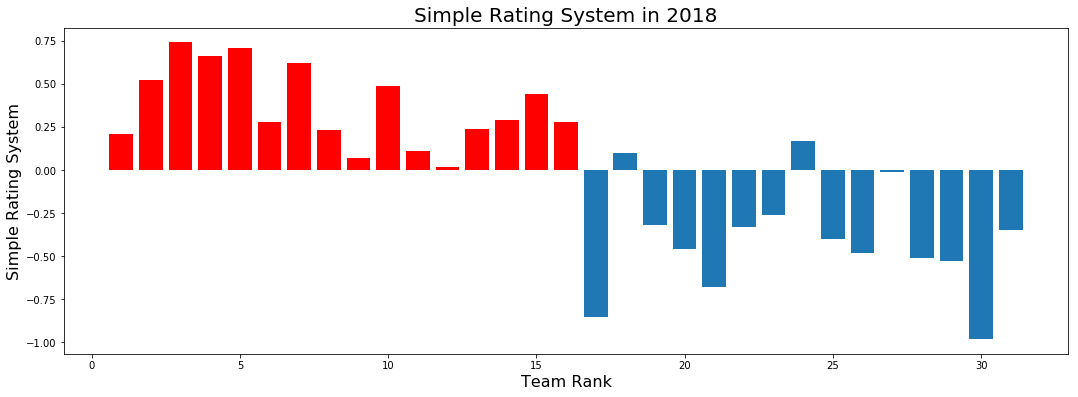

In [41]:
df_2018 = full_df[full_df['year'] == 2018]
df_2018_playoffs = df_2018[df_2018['rank'] <= 16]
df_2018_bottom = df_2018[df_2018['rank'] > 16]

plt.figure(figsize=(18,6))
bar1 = plt.bar(x = df_2018_playoffs['rank'], height = df_2018_playoffs['srs'], color='r')
bar2 = plt.bar(x = df_2018_bottom['rank'], height = df_2018_bottom['srs'])
plt.title('Simple Rating System in 2018', fontsize=20)
plt.xlabel('Team Rank', fontsize=16)
plt.ylabel('Simple Rating System', fontsize=16)

Simple Rating System; a team rating that takes into account average goal differential and strength of schedule. The rating is denominated in goals above/below average, where zero is average.

### Conclusions

 - While there are some strong correlations to team rank, they are largely due to summary team statistics like wins, losses, points etc. 
 - There are a high amount of interactions and multicollinearity at work here. With more time I would like to dive deeper into feature engineering and really create more of my own statistics.
 - As stated previously, sports are terribly hard to predict, and I don't expect my model to be highly accurate.

In [43]:
full_df.head()

games  goals  goals_against_ev  goals_ev  goals_pp  losses  opp_goals  \
0   82.0  267.0             145.0     193.0      58.0    18.0      211.0   
1   82.0  277.0             159.0     200.0      64.0    20.0      218.0   
2   82.0  296.0             172.0     216.0      66.0    23.0      236.0   
3   82.0  270.0             161.0     197.0      61.0    20.0      214.0   
4   82.0  272.0             182.0     218.0      53.0    24.0      228.0   

   opp_goals_pp    pdo  pen_kill_pct  points  points_pct  power_play_pct  \
0          54.0  101.6         81.94   117.0       0.713           21.17   
1          50.0  101.0         81.75   114.0       0.695           23.36   
2          64.0  102.0         76.03   113.0       0.689           23.91   
3          40.0  100.2         83.67   112.0       0.683           23.64   
4          44.0  100.5         81.43   109.0       0.665           21.37   

   save_pct  shot_pct   sos   srs             team_name  wins  year  \
0     0.923       9.9  0.03  0.71   Nashville Predators  53.0  2018   
1     0.917      10.3  0.02  0.74         Winnipeg Jets  52.0  2018   
2     0.912      10.7 -0.07  0.66   Tampa Bay Lightning  54.0  2018   
3     0.912       9.9 -0.07  0.62         Boston Bruins  50.0  2018   
4     0.911      10.1 -0.01  0.52  Vegas Golden Knights  51.0  2018   

   cup_champs  rank  avg_corsi_pct  player_point_avg  avg_plus_minus  \
0         0.0     5      49.660000         25.481481        9.185185   
1         0.0     3      51.061538         26.285714        7.250000   
2         0.0     4      51.536000         28.962963        9.333333   
3         0.0     7      53.162069         23.161290        5.419355   
4         0.0     2      50.779167         26.000000        5.037037   

    avg_ops   avg_dps    avg_ps  fenwick_pct  score_balance_pct  ev_goal_diff  \
0  1.692593  1.700000  4.103704    49.836000           0.388889          48.0   
1  1.792857  1.567857  3.925000    51.357692           0.277778          41.0   
2  2.103704  1.407407  4.085185    51.576000           0.388889          44.0   
3  1.554839  1.509677  3.512903    53.320690           0.277778          36.0   
4  1.788889  1.518519  3.807407    50.770833           0.277778          36.0   

   special_teams_diff  
0                 4.0  
1                14.0  
2                 2.0  
3                21.0  
4                 9.0

#### Saving final dataframe to csv

In [44]:
full_df.to_csv('model data.csv')